## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


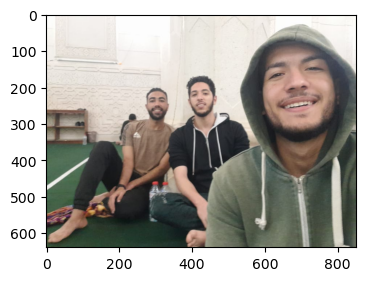

In [67]:
import cv2
## load in color image for face detection
image = cv2.imread('images/2.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
gray = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(4,4))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>

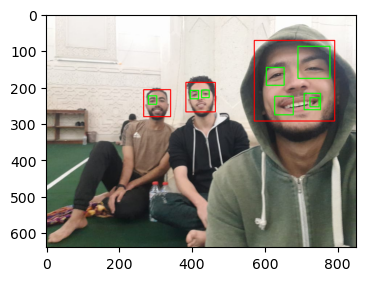

In [68]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# load in a haar cascade classifier for detecting eyes
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),2) #2
    
    # draw a rectangle around each detected eyes
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = image_with_detections[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

fig = plt.figure(figsize=(4,4))

plt.imshow(image_with_detections);

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [69]:
import torch
from model import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_2.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

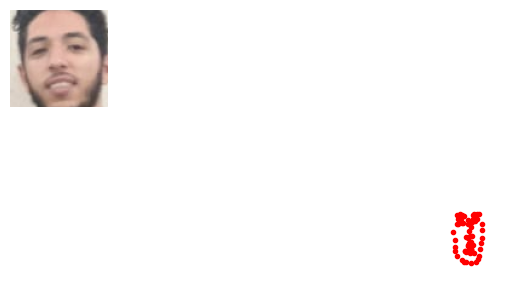

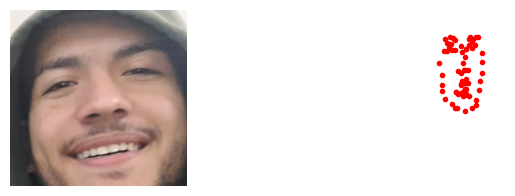

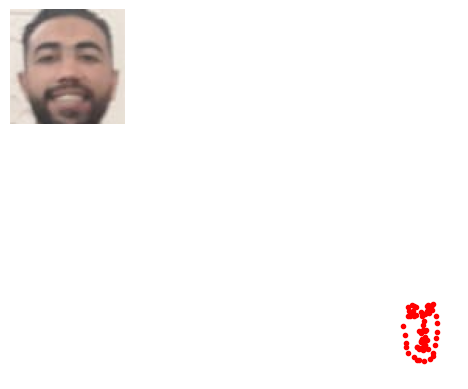

In [94]:
# Create a copy of the image
image_copy = np.copy(image)

# Define a helper function to display the keypoints on the image
def show_keypoints(image, keypoints):
    #fig = plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='.')
    plt.axis('off')
    plt.show()

# Loop over the detected faces from your Haar cascade
for (x, y, w, h) in faces:
    # Select the region of interest that is the face in the image
    roi = image_copy[y:y+h, x:x+w]

    # Convert the face region from RGB to grayscale
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    # Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi_norm = roi_gray / 255.0

    # Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    resized_roi = cv2.resize(roi_norm, (224, 224))

    # Reshape the numpy image shape (H x W) into a torch image shape (C x H x W)
    roi_tensor = torch.from_numpy(resized_roi).unsqueeze(0).unsqueeze(0).float()

    # Make facial keypoint predictions using your loaded, trained network
    with torch.no_grad():
        pred = net(roi_tensor)

    # Reshape the predicted tensor to have shape (68, 2)
    keypoints = pred.view(68, 2).numpy()
    #keypoints = keypoints.astype('float').reshape(-1, 2)

    # Scale the keypoints back to the original coordinate range
    keypoints = keypoints * (w / 224.0) + np.array([[x, y]])

    # Display each detected face and the corresponding keypoints
    show_keypoints(roi, keypoints)